# LangGraph Streaming Outputs

**LangGraph Streaming Outputs (Luồng Đầu ra LangGraph)** khám phá khả năng phát luồng từng bước trong LangGraph.

Phương pháp này cho phép các nhà phát triển quan sát và tương tác với từng giai đoạn xử lý đồ thị trong thời gian thực, cung cấp thông tin chi tiết về hoạt động bên trong và tiến trình của các phép tính đồ thị.

- **Step-by-Step Streaming (Phát luồng từng bước)**
   Chức năng phát luồng chia quá trình thực thi đồ thị thành các bước riêng lẻ, cung cấp đầu ra chi tiết ở mỗi giai đoạn. Điều này giúp gỡ lỗi và hiểu cách dữ liệu luân chuyển qua đồ thị, cũng như cách đưa ra quyết định trên đường đi, trở nên dễ dàng hơn.

- **Real-Time Feedback (Phản hồi theo thời gian thực)**
   Bằng cách tận dụng đầu ra phát luồng, người dùng nhận được phản hồi ngay lập tức từ hệ thống. Sự tương tác theo thời gian thực này có thể nâng cao đáng kể quá trình gỡ lỗi và khả năng tinh chỉnh cấu hình đồ thị một cách nhanh chóng.

- **Enhanced Transparency and Control (Tăng cường tính minh bạch và kiểm soát)**
   Đầu ra phát luồng mang lại tính minh bạch cao hơn cho việc thực thi các pipeline LangGraph. Người dùng có thể theo dõi từng phép biến đổi hoặc tính toán, cho phép kiểm soát chính xác hơn quá trình và tạo điều kiện hiểu sâu hơn về các quy trình làm việc dựa trên đồ thị phức tạp.


In [1]:
from typing import Annotated, TypedDict, List, Dict
from langchain_core.tools import tool
from langchain_ollama import ChatOllama
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from GoogleNews import GoogleNews

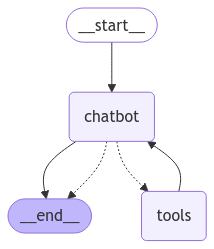

In [15]:
# 1. State Definition
from unittest import result


class State(TypedDict):
    # Define messages (a list type, with the add_messages function used to append messages)
    messages: Annotated[list, add_messages]
    dummy_data: Annotated[str, "dummy"]

# 2. Tool definition and binding tool
# news_tool = GoogleNews()

@tool
def search_keyword(query: str) -> List[Dict[str, str]]:
    """Look up news by keyword"""
    news_tool = GoogleNews()
    news_tool.search(query)
    results = news_tool.results(sort=True)
    # Limit to top 5 results
    limited_results = results[:5] if results else []
    # Extract title and link from each result
    return [{"title": item["title"], "link": item["link"]} for item in limited_results]

tools = [search_keyword]

llm = ChatOllama(model='mistral:7b', temperature=0)
llm_with_tools = llm.bind_tools(tools)

### 3. Add node

def chatbot(state: State):
    # Invoke and return messages
    return {
        "messages": [llm_with_tools.invoke(state["messages"])],
        "dummy_data": "[chatbot] called, dummy data",  # Add dummy data for testing
    }

graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition
)

# 4. Edge
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("chatbot", END)

graph = graph_builder.compile()
graph

In [16]:
question = "Thông tin giá nhà đất mới nhất ở Hà Nội"

search_keyword(question)

[{'title': 'Bộ trưởng Công Thương: Mua 0 đồng điện mặt trời mái nhà để ngăn trục lợi',
  'link': 'https://vnexpress.net/dien-mat-troi-mai-nha-tu-dung-ban-0-dong-de-ngan-truc-loi-4738446.html&ved=2ahUKEwjRhMCYlp6MAxW8kVYBHXzDJawQxfQBegQIBBAC&usg=AOvVaw0XBHsvmBkk_cnZqt-aeyVq'},
 {'title': 'Chờ 30 Tết mua đào, quất giá rẻ',
  'link': 'https://vnexpress.net/cho-30-tet-mua-dao-quat-gia-re-4843230.html&ved=2ahUKEwjRhMCYlp6MAxW8kVYBHXzDJawQxfQBegQIChAC&usg=AOvVaw2TD4Bm19FX8HwaTc7o2w-Q'},
 {'title': 'Tổng Bí thư giải thích nguyên nhân tinh gọn bộ máy trước Đại hội Đảng 14',
  'link': 'https://vnexpress.net/tong-bi-thu-giai-thich-nguyen-nhan-tinh-gon-bo-may-truoc-dai-hoi-dang-14-4849055.html&ved=2ahUKEwjRhMCYlp6MAxW8kVYBHXzDJawQxfQBegQICBAC&usg=AOvVaw3RwidaDncrmgDoVT5IMbeO'},
 {'title': 'Giá chung cư tại TP. Hồ Chí Minh - cập nhật mới nhất hiện nay',
  'link': 'https://baothanhhoa.vn/gia-chung-cu-tai-tp-ho-chi-minh-cap-nhat-moi-nhat-hien-nay-233821.htm&ved=2ahUKEwjRhMCYlp6MAxW8kVYBHXzDJawQxfQBe

## The stream Method of StateGraph

Phương thức `stream` cung cấp khả năng phát trực tuyến (stream) các bước đồ thị cho một đầu vào đơn lẻ.

**Tham số**
- `input` (`Union[dict[str, Any], Any]` ) : Đầu vào cho đồ thị
- `config` (`Optional[RunnableConfig]` ) : Cấu hình thực thi
- `stream_mode` (`Optional[Union[StreamMode, list[StreamMode]]]` ) : Chế độ phát trực tuyến đầu ra
- `output_keys` (`Optional[Union[str, Sequence[str]]]` ) : Các khóa (keys) để phát trực tuyến
- `interrupt_before` (`Optional[Union[All, Sequence[str]]]` ) : Các nút (nodes) để ngắt trước khi thực thi
- `interrupt_after` (`Optional[Union[All, Sequence[str]]]` ) : Các nút (nodes) để ngắt sau khi thực thi
- `debug` (`Optional[bool]` ) : Có xuất thông tin gỡ lỗi (debug) hay không
- `subgraphs` (`bool`) : Có phát trực tuyến các đồ thị con (subgraphs) hay không

**Trả về**
- `Iterator[Union[dict[str, Any], Any]]` : Đầu ra từ mỗi bước của đồ thị. Định dạng đầu ra phụ thuộc vào `stream_mode` .

**Các tính năng chính**
1. Xử lý việc thực thi đồ thị theo kiểu phát trực tuyến (streaming) theo cấu hình đã cho
2. Hỗ trợ nhiều chế độ phát trực tuyến (`values`, `updates`, `debug`)
3. Quản lý các callbacks và xử lý lỗi
4. Xử lý giới hạn đệ quy (recursion limits) và điều kiện ngắt (interruption conditions)

**Các chế độ phát trực tuyến**
- `values` : Xuất các giá trị trạng thái hiện tại ở mỗi bước
- `updates` : Chỉ xuất các cập nhật trạng thái ở mỗi bước
- `debug` : Xuất các sự kiện gỡ lỗi (debug events) ở mỗi bước


In [17]:
from langchain_core.runnables import RunnableConfig

question = "Thông tin giá nhà đất mới nhất ở Hà Nội"

input = State(
    messages=[("user", question)],
    dummy_data="Test string"
)

# Configure config
config = RunnableConfig(
    recursion_limit=10,
    configurable={"thread_id": "1"},
    tags=["my-tag"]
)

In [18]:
for event in graph.stream(input=input, config=config):
    for key, value in event.items():
        print(f"\n[ {key} ]\n")
        # If messages exist in value
        if "messages" in value:
            messages = value["messages"]
            # Print only the most recent message
            value["messages"][-1].pretty_print()


[ chatbot ]

================================== Ai Message ==================================
Tool Calls:
  search_keyword (b69aac49-48e7-4de0-80d4-2dc6b9b75201)
 Call ID: b69aac49-48e7-4de0-80d4-2dc6b9b75201
  Args:
    query: giá nhà đất mới nhất ở Hà Nội

[ tools ]

================================= Tool Message =================================
Name: search_keyword

[{"title": "Viet Nam is fastest growing country in Southeast Asia: USABC President", "link": "https://thoibaotaichinhvietnam.vn/viet-nam-is-fastest-growing-country-in-southeast-asia-usabc-president-172803.html&ved=2ahUKEwjXl86dlp6MAxXf3zQHHReQKDoQxfQBegQIARAC&usg=AOvVaw3vVa7tnnfaV5sTZyqNfPvC"}, {"title": "Vinh Phuc starts construction of social housing project in Phuc Yen city", "link": "https://baohaiduong.vn/en/vinh-phuc-khoi-cong-du-an-nha-o-xa-hoi-o-tp-phuc-yen-406128.html&ved=2ahUKEwjXl86dlp6MAxXf3zQHHReQKDoQxfQBegQICBAC&usg=AOvVaw2F7umDmSyzomB5yj2x9Dv7"}, {"title": "Vietnam, RoK strengthen energy cooperation", "l

## Advanced Streaming Options

Các tùy chọn phát trực tuyến nâng cao trong LangGraph cho phép kiểm soát chi tiết hơn về cách xử lý đầu ra thực thi đồ thị. Bằng cách cấu hình các tham số như `output_keys`, `stream_mode`, `interrupt_before` và `interrupt_after`, người dùng có thể điều chỉnh hành vi phát trực tuyến theo nhu cầu gỡ lỗi và giám sát cụ thể của họ.

### Tùy chọn output_keys

Tùy chọn `output_keys` được sử dụng để chỉ định các khóa (keys) cần phát trực tuyến.

Bạn có thể chỉ định nó ở định dạng danh sách (list) và nó phải là một trong các khóa được định nghĩa trong **channels**.

**Lời khuyên**

- Nếu một số lượng lớn các khóa State được xuất ra ở mỗi bước, điều này hữu ích khi bạn chỉ muốn phát trực tuyến một số trong số chúng.


In [19]:
print(graph.channels.keys())

dict_keys(['messages', 'dummy_data', '__start__', 'chatbot', 'branch:to:chatbot', 'tools', 'branch:to:tools', 'start:chatbot'])


In [20]:
question = "Những thông tin mới nhất về giá chung cư tại Hà Nội"

input = State(dummy_data="Test string", messages=[("user", question)])

config = RunnableConfig(
    recursion_limit=10,
    configurable={"thread_id": "1"},
    tags=["my-rag"]
)

for event in graph.stream(
    input=input,
    config=config,
    output_keys=["dummy_data"]
):
    for key, value in event.items():
        # key is the node name
        print(f"\n[ {key} ]\n")

        # If dummy_data exists
        if value:
            # value is the node output
            print(value.keys())
            if "dummy_data" in value:
                print(value["dummy_data"])


[ chatbot ]

dict_keys(['dummy_data'])
[chatbot] called, dummy data

[ tools ]


[ chatbot ]

dict_keys(['dummy_data'])
[chatbot] called, dummy data


In [21]:

# Define the initial input State
input = State(dummy_data="Test string", messages=[("user", question)])

# Configure config
config = RunnableConfig(
    recursion_limit=10,  # Visit up to 10 nodes; beyond that, RecursionError will occur
    configurable={"thread_id": "1"},  # Set the thread ID
    tags=["my-rag"],  # Tag
)

for event in graph.stream(
    input=input,
    config=config,
    output_keys=["messages"],  # Only output messages
):
    for key, value in event.items():
        # If messages exist
        if value and "messages" in value:
            # key is the node name
            print(f"\n[ {key} ]\n")
            # Print the content of the last message
            print(value["messages"][-1].content)


[ chatbot ]



[ tools ]

[{"title": "Vietnam aims for 454 billion USD export revenue amidst global headwinds", "link": "https://thoibaotaichinhvietnam.vn/vietnam-aims-for-454-billion-usd-export-revenue-amidst-global-headwinds-172652.html&ved=2ahUKEwjOsYvNrJ6MAxVwslYBHYoiEhYQxfQBegQIBxAC&usg=AOvVaw2jqx8dFyt44ydm9lr41Gzc"}, {"title": "There are no apartments for rent under 10 million VND per month in the center of Hanoi", "link": "https://baohaiduong.vn/en/vang-bong-can-ho-cho-thue-duoi-10-trieu-dong-1-thang-tai-trung-tam-ha-noi-406842.html&ved=2ahUKEwjOsYvNrJ6MAxVwslYBHYoiEhYQxfQBegQIChAC&usg=AOvVaw1hkG5bxMhrHEk9MzSRKX-s"}, {"title": "Young Vietnamese flock back to empty nest as housing becomes unaffordable", "link": "https://e.vnexpress.net/news/business/property/young-vietnamese-flock-back-to-empty-nest-as-housing-becomes-unaffordable-4853468.html&ved=2ahUKEwjOsYvNrJ6MAxVwslYBHYoiEhYQxfQBegQIBRAC&usg=AOvVaw3ebATD8k8Yih8Wic2SfcBe"}, {"title": "Chờ 30 Tết mua đào, quất giá rẻ", "link"

### The stream_mode Option

Tùy chọn `stream_mode` được sử dụng để chỉ định chế độ xuất luồng (streaming output mode).

- `values`: Xuất các giá trị trạng thái hiện tại ở mỗi bước.
- `updates`: Chỉ xuất các cập nhật trạng thái ở mỗi bước (mặc định).

### stream_mode = "values"

Ở chế độ `values`, các giá trị trạng thái hiện tại của mỗi bước được xuất ra.

**Lưu ý**

`event.items()`

- `key`: Khóa của State.
- `value`: Giá trị tương ứng với khóa của State.


In [22]:
# Question
question = "Please provide the latest news about the 2024 Nobel Prize in Literature."

# Define the initial input State
input = State(dummy_data="Test string", messages=[("user", question)])

# Configure config
config = RunnableConfig(
    recursion_limit=10,  # Visit up to 10 nodes; beyond that, RecursionError will occur
    configurable={"thread_id": "1"},  # Set the thread ID
    tags=["my-rag"],  # Tag
)

# Stream output in values mode
for event in graph.stream(
    input=input,
    stream_mode="values",  # Default
):
    for key, value in event.items():
        # key is the State key
        print(f"\n[ {key} ]\n")
        if key == "messages":
            print(f"Number of messages: {len(value)}")
    print("===" * 10, " Step ", "===" * 10)


[ messages ]

Number of messages: 1

[ dummy_data ]

==============================  Step  ==============================

[ messages ]

Number of messages: 2

[ dummy_data ]

==============================  Step  ==============================

[ messages ]

Number of messages: 3

[ dummy_data ]

==============================  Step  ==============================

[ messages ]

Number of messages: 4

[ dummy_data ]

==============================  Step  ==============================


### stream_mode = "updates"

Ở chế độ `updates`, chỉ State được cập nhật cho mỗi bước được xuất ra.

- Đầu ra là một từ điển (dictionary) mà khóa (key) là tên nút (node name), và các giá trị (values) là các đầu ra được cập nhật.

**Lưu ý**

`event.items()`

- `key`: Tên nút (node name).
- `value`: Đầu ra của nút đó dưới dạng từ điển (dictionary) (nó có thể có nhiều cặp key-value).


In [23]:
# Question
question = "Please provide the latest news about the 2024 Nobel Prize in Literature."

# Define the initial input State
input = State(dummy_data="Test string", messages=[("user", question)])

# Configure config
config = RunnableConfig(
    recursion_limit=10,  # Visit up to 10 nodes; beyond that, RecursionError will occur
    configurable={"thread_id": "1"},  # Set the thread ID
    tags=["my-rag"],  # Tag
)

# Stream output in updates mode
for event in graph.stream(
    input=input,
    stream_mode="updates",  # Default
):
    for key, value in event.items():
        # key is the node name
        print(f"\n[ {key} ]\n")

        # value is the output of the node
        print(value.keys())

        # The state is stored in dict form under the keys of 'values'
        if "messages" in value:
            print(f"Number of messages: {len(value['messages'])}")
    print("===" * 10, " Step ", "===" * 10)


[ chatbot ]

dict_keys(['messages', 'dummy_data'])
Number of messages: 1
==============================  Step  ==============================

[ tools ]

dict_keys(['messages'])
Number of messages: 1
==============================  Step  ==============================

[ chatbot ]

dict_keys(['messages', 'dummy_data'])
Number of messages: 1
==============================  Step  ==============================


### The interrupt_before and interrupt_after Options

Các tùy chọn `interrupt_before` và `interrupt_after` được sử dụng để chỉ định thời điểm ngắt luồng (interrupt streaming).

- `interrupt_before`: Ngắt luồng trước nút được chỉ định.
- `interrupt_after`: Ngắt luồng sau nút được chỉ định.


In [24]:
# Question
question = "Please provide the latest news about the 2024 Nobel Prize in Literature."

# Define the initial input State
input = State(dummy_data="Test string", messages=[("user", question)])

# Configure config
config = RunnableConfig(
    recursion_limit=10,  # Visit up to 10 nodes; beyond that, RecursionError will occur
    configurable={"thread_id": "1"},  # Set the thread ID
    tags=["my-rag"],  # Tag
)

for event in graph.stream(
    input=input,
    config=config,
    stream_mode="updates",  # Default
    interrupt_before=["tools"],  # Interrupt before the 'tools' node
):
    for key, value in event.items():
        # key is the node name
        print(f"\n[{key}]\n")

        # value is the node's output
        if isinstance(value, dict):
            print(value.keys())
            if "messages" in value:
                print(value["messages"])

        # The state is stored as a dict (keys of 'values')
        if "messages" in value:
            print(f"Number of messages: {len(value['messages'])}")
    print("===" * 10, " Step ", "===" * 10)


[chatbot]

dict_keys(['messages', 'dummy_data'])
[AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'mistral:7b', 'created_at': '2025-03-22T18:49:15.4478063Z', 'done': True, 'done_reason': 'stop', 'total_duration': 4222846600, 'load_duration': 9313400, 'prompt_eval_count': 79, 'prompt_eval_duration': 222126400, 'eval_count': 281, 'eval_duration': 3988349100, 'message': Message(role='assistant', content='', images=None, tool_calls=None)}, id='run-86d35823-d16e-417f-b0ad-c82739edf3be-0', tool_calls=[{'name': 'search_keyword', 'args': {'query': '2024 Nobel Prize in Literature'}, 'id': 'db3ab7d9-8c7a-4232-97aa-495fcacee0e3', 'type': 'tool_call'}], usage_metadata={'input_tokens': 79, 'output_tokens': 281, 'total_tokens': 360})]
Number of messages: 1
==============================  Step  ==============================

[__interrupt__]

==============================  Step  ==============================


In [25]:
# Question
question = "Please provide the latest news about the 2024 Nobel Prize in Literature."

# Define the initial input State
input = State(dummy_data="Test string", messages=[("user", question)])

# Configure config
config = RunnableConfig(
    recursion_limit=10,  # Visit up to 10 nodes; beyond that, RecursionError will occur
    configurable={"thread_id": "1"},  # Set the thread ID
    tags=["my-rag"],  # Tag
)

for event in graph.stream(
    input=input,
    config=config,
    stream_mode="updates",
    interrupt_after=["tools"],  # Interrupt after executing 'tools'
):
    for value in event.values():
        # key is the node name
        print(f"\n[{key}]\n")

        if isinstance(value, dict):
            # value is the node's output
            print(value.keys())
            if "messages" in value:
                print(value["messages"])

        # The state is stored as a dict (keys of 'values')
        if "messages" in value:
            print(f"Number of messages: {len(value['messages'])}")


[__interrupt__]

dict_keys(['messages', 'dummy_data'])
[AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'mistral:7b', 'created_at': '2025-03-22T18:49:27.1189992Z', 'done': True, 'done_reason': 'stop', 'total_duration': 4029325700, 'load_duration': 9639900, 'prompt_eval_count': 79, 'prompt_eval_duration': 3135300, 'eval_count': 261, 'eval_duration': 4004665400, 'message': Message(role='assistant', content='', images=None, tool_calls=None)}, id='run-bbc38d83-96d3-47ba-8268-62f9a11d85c4-0', tool_calls=[{'name': 'search_keyword', 'args': {'query': '2024 Nobel Prize in Literature'}, 'id': 'f396c39f-f7ba-42cf-8c64-de52bb7ae0a3', 'type': 'tool_call'}], usage_metadata={'input_tokens': 79, 'output_tokens': 261, 'total_tokens': 340})]
Number of messages: 1

[__interrupt__]

dict_keys(['messages'])
[ToolMessage(content='[{"title": "Women of the World: 2024’s Nobel Prize in Literature Winner, South Korean author Han Kang", "link": "https://theboar.org/2025/03/women-of-the-